In [3]:
import numpy as np
print("numpy version - {}".format(np.__version__))
import pandas as pd
print("pandas version - {}".format(pd.__version__))
import matplotlib
print("matplotlib version - {}".format(matplotlib.__version__))
import matplotlib.pyplot as plt
import seaborn as sns
print("seaborn version - {}".format(sns.__version__))
import tensorflow as tf
print("tensorflow version - {}".format(tf.__version__))
import sklearn
print("sklearn version - {}".format(sklearn.__version__))
%matplotlib inline
import xgboost
print("xgboost version - {}".format(xgboost.__version__))
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from xgboost import plot_importance

numpy version - 1.17.4
pandas version - 0.25.3
matplotlib version - 3.1.2
seaborn version - 0.9.0
tensorflow version - 2.0.0
sklearn version - 0.21.3
xgboost version - 0.90


In [4]:
import datetime
import random
import time
import sys
import gc
import pickle
from itertools import product
import warnings
warnings.filterwarnings("ignore")

In [5]:
data_path = '../data/competitive-data-science-predict-future-sales'

In [6]:
!ls ../data/competitive-data-science-predict-future-sales

item_categories.csv  sales_train.csv	    shops.csv
items.csv	     sample_submission.csv  test.csv


In [7]:
item_cat = pd.read_csv(data_path + '/item_categories.csv')
items = pd.read_csv(data_path + '/items.csv')
shops = pd.read_csv(data_path + '/shops.csv')
train = pd.read_csv(data_path + '/sales_train.csv')
test = pd.read_csv(data_path + '/test.csv').set_index('ID')
sample_sub = pd.read_csv(data_path + '/sample_submission.csv')

In [8]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06,2.935849e+06
mean,1.456991e+01,3.300173e+01,1.019723e+04,8.908532e+02,1.242641e+00
std,9.422988e+00,1.622697e+01,6.324297e+03,1.729800e+03,2.618834e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,7.000000e+00,2.200000e+01,4.476000e+03,2.490000e+02,1.000000e+00
50%,1.400000e+01,3.100000e+01,9.343000e+03,3.990000e+02,1.000000e+00
75%,2.300000e+01,4.700000e+01,1.568400e+04,9.990000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216900e+04,3.079800e+05,2.169000e+03


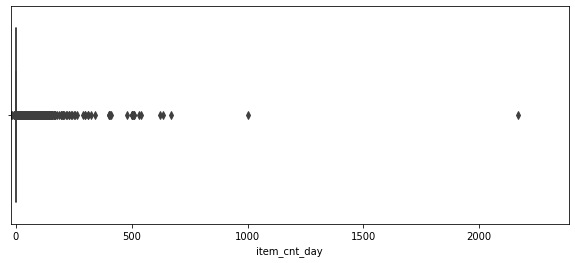

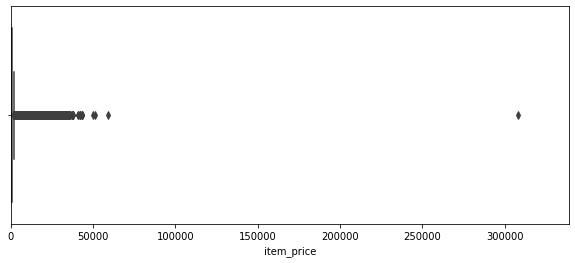

In [9]:
plt.figure(figsize=(10, 4))
plt.xlim(train.item_cnt_day.min(), train.item_cnt_day.max()*1.1)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10, 4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

In [10]:
train = train[train.item_price < 100000]
train = train[train.item_price < 1001]

In [11]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2.273401e+06,2.273401e+06,2.273401e+06,2.273401e+06,2.273401e+06
mean,1.386149e+01,3.330404e+01,1.096339e+04,3.989382e+02,1.217258e+00
std,9.307405e+00,1.624808e+01,6.299248e+03,2.523668e+02,2.419032e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,-2.200000e+01
25%,6.000000e+00,2.200000e+01,5.305000e+03,1.990000e+02,1.000000e+00
50%,1.300000e+01,3.100000e+01,1.099100e+04,3.490000e+02,1.000000e+00
75%,2.200000e+01,4.800000e+01,1.622700e+04,5.490000e+02,1.000000e+00
max,3.300000e+01,5.900000e+01,2.216800e+04,1.000860e+03,2.169000e+03


In [12]:
train[train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [13]:
median = train[train.item_price >= 0].item_price.median()
median

349.0

In [14]:
train.loc[train.item_price < 0, 'item_price'] = median

In [15]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11


In [16]:
item_cat.sample(5)

,item_category_name,item_category_id
7,Аксессуары - XBOX ONE,7
70,Подарки - Сувениры (в навеску),70
16,Игровые консоли - XBOX ONE,16
40,Кино - DVD,40
12,Игровые консоли - PS4,12


In [17]:
items.sample(5)

,item_name,item_id,item_category_id
1612,B.B. KING Live In The Montreux 1993 Blu-Ray ...,1612,59
15093,Микроробот Ларва Зомби,15093,62
8810,БЕРКОВСКИЙ ВИКТОР Песни нашего века,8810,55
12520,КЛАССИКА Romantic Classics Best 2,12520,55
21990,Шолохов Михаил Тихий Дон 3CD (mp3-CD) (Jewel),21990,43


In [18]:
shops.sample(5)

,shop_name,shop_id
52,"Уфа ТК ""Центральный""",52
21,"Москва МТРЦ ""Афи Молл""",21
19,"Курск ТЦ ""Пушкинский""",19
40,"РостовНаДону ТРК ""Мегацентр Горизонт"" Островной",40
35,"Н.Новгород ТРЦ ""Фантастика""",35


In [19]:
train.sample(5)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2142280,23.11.2014,22,15,4261,499.0,1.0
2535057,14.03.2015,26,6,17125,399.0,1.0
53054,05.01.2013,0,8,14447,499.0,1.0
171710,04.02.2013,1,6,1249,299.0,1.0
2562736,11.04.2015,27,31,10180,249.0,1.0


In [20]:
[shop_name for shop_name in shops['shop_name']]

['!Якутск Орджоникидзе, 56 фран',
 '!Якутск ТЦ "Центральный" фран',
 'Адыгея ТЦ "Мега"',
 'Балашиха ТРК "Октябрь-Киномир"',
 'Волжский ТЦ "Волга Молл"',
 'Вологда ТРЦ "Мармелад"',
 'Воронеж (Плехановская, 13)',
 'Воронеж ТРЦ "Максимир"',
 'Воронеж ТРЦ Сити-Парк "Град"',
 'Выездная Торговля',
 'Жуковский ул. Чкалова 39м?',
 'Жуковский ул. Чкалова 39м²',
 'Интернет-магазин ЧС',
 'Казань ТЦ "Бехетле"',
 'Казань ТЦ "ПаркХаус" II',
 'Калуга ТРЦ "XXI век"',
 'Коломна ТЦ "Рио"',
 'Красноярск ТЦ "Взлетка Плаза"',
 'Красноярск ТЦ "Июнь"',
 'Курск ТЦ "Пушкинский"',
 'Москва "Распродажа"',
 'Москва МТРЦ "Афи Молл"',
 'Москва Магазин С21',
 'Москва ТК "Буденовский" (пав.А2)',
 'Москва ТК "Буденовский" (пав.К7)',
 'Москва ТРК "Атриум"',
 'Москва ТЦ "Ареал" (Беляево)',
 'Москва ТЦ "МЕГА Белая Дача II"',
 'Москва ТЦ "МЕГА Теплый Стан" II',
 'Москва ТЦ "Новый век" (Новокосино)',
 'Москва ТЦ "Перловский"',
 'Москва ТЦ "Семеновский"',
 'Москва ТЦ "Серебряный Дом"',
 'Мытищи ТРК "XL-3"',
 'Н.Новгород ТРЦ

In [21]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id', 'city_code']]

In [22]:
shops.sample(5)

,shop_id,city_code
11,11,6
46,46,21
16,16,10
48,48,23
13,13,8


In [23]:
item_cat['split'] = item_cat['item_category_name'].str.split('-')
item_cat['type'] = item_cat['split'].map(lambda x: x[0].strip())
item_cat['type_code'] = LabelEncoder().fit_transform(item_cat['type'])
item_cat['subtype'] = item_cat['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cat['subtype_code'] = LabelEncoder().fit_transform(item_cat['subtype'])
item_cat = item_cat[['item_category_id', 'type_code', 'subtype_code']]

In [24]:
item_cat.sample(5)

,item_category_id,type_code,subtype_code
40,40,11,4
0,0,0,29
30,30,8,55
78,78,15,45
31,31,8,61


In [25]:
items.drop(['item_name'], axis=1, inplace=True)

In [26]:
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)

(1312, 5100, 214200)

In [27]:
ts = time.time()
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)
time.time() - ts

7.940450429916382

In [28]:
matrix

,date_block_num,shop_id,item_id
102544,0,2,19
107797,0,2,28
102258,0,2,32
102259,0,2,33
102260,0,2,34
...,...,...,...
9109555,33,59,22162
9109719,33,59,22163
9110256,33,59,22164
9111363,33,59,22166


In [29]:
train['revenue'] = train['item_price'] * train['item_cnt_day']

In [30]:
ts = time.time()
group = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day':['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                            .fillna(0)
                            .clip(0, 20)
                            .astype(np.float16))
time.time() - ts

3.317894220352173

In [31]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)
time.time() - ts

0.13988947868347168

In [32]:
matrix.sample()

,date_block_num,shop_id,item_id,item_cnt_month
2918149,8.0,45,13999,0.0


In [33]:
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, item_cat, on=['item_category_id'], how='left')
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

2.4301955699920654

In [34]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [35]:
ts = time.time()
matrix = lag_feature(matrix, [1, 2, 3, 6, 12], 'item_cnt_month')
time.time() - ts

30.298659324645996

In [36]:
ts = time.time()
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

8.800445318222046

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

In [ ]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts